# **Imports and Setup**

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/FWD/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/FWD/labels.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/DEF/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/DEF/labels.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/MID/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/MID/labels.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/GK/inputs.csv .
!cp drive/MyDrive/Premier_League_Predictor/train_2018-24/GK/labels.csv .
!pip install catboost

Mounted at /content/drive/


In [3]:
# Import Packages (pretty standard stuff)
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Stuff
from sklearn import utils
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, accuracy_score
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from tensorflow import keras
from keras import layers, Sequential

# Saving Trained Models
import os
import joblib

# Disable Nonsense Output
import warnings
warnings.filterwarnings('ignore')

# **Data Loading and Exploration**

In [5]:
# 80-20 train test split
split                           = 0.2

X_train, y_train, X_test, y_test= {}, {}, {}, {}
positions                       = ["FWD", "MID", "DEF", "GK"]
for pos in positions:
    input_data                  = pd.read_csv(f'drive/MyDrive/Premier_League_Predictor/train_2018-24/{pos}/inputs.csv')
    labels                      = pd.read_csv(f'drive/MyDrive/Premier_League_Predictor/train_2018-24/{pos}/labels.csv')
    data                        = pd.concat([input_data, labels['Points']], axis=1)

    drops                       = ["penalties_missed"] if pos == "GK" else ["saves", "penalties_saved"] + (["penalties_missed"] if pos == "DEF" else [])
    drops                       = [f"{j}_{i}" for j in (drops) for i in range(1, 6)]

    num_rows                    = len(data)
    test_indices                = np.random.choice(num_rows, size=int(split * num_rows), replace=False)
    train_data                  = data.drop(test_indices)
    test_data                   = data.loc[test_indices]
    X_train[pos]                = train_data.drop(columns = ['Points'] + drops, axis=1)
    y_train[pos]                = train_data['Points']
    X_test[pos]                 = test_data.drop(columns = ['Points'] + drops, axis=1)
    y_test[pos]                 = test_data['Points']

    print(X_train[pos].shape, y_train[pos].shape, X_test[pos].shape, y_test[pos].shape)

(5570, 97) (5570,) (1392, 97) (1392,)
(22482, 97) (22482,) (5620, 97) (5620,)
(18595, 92) (18595,) (4648, 92) (4648,)
(6261, 102) (6261,) (1565, 102) (1565,)


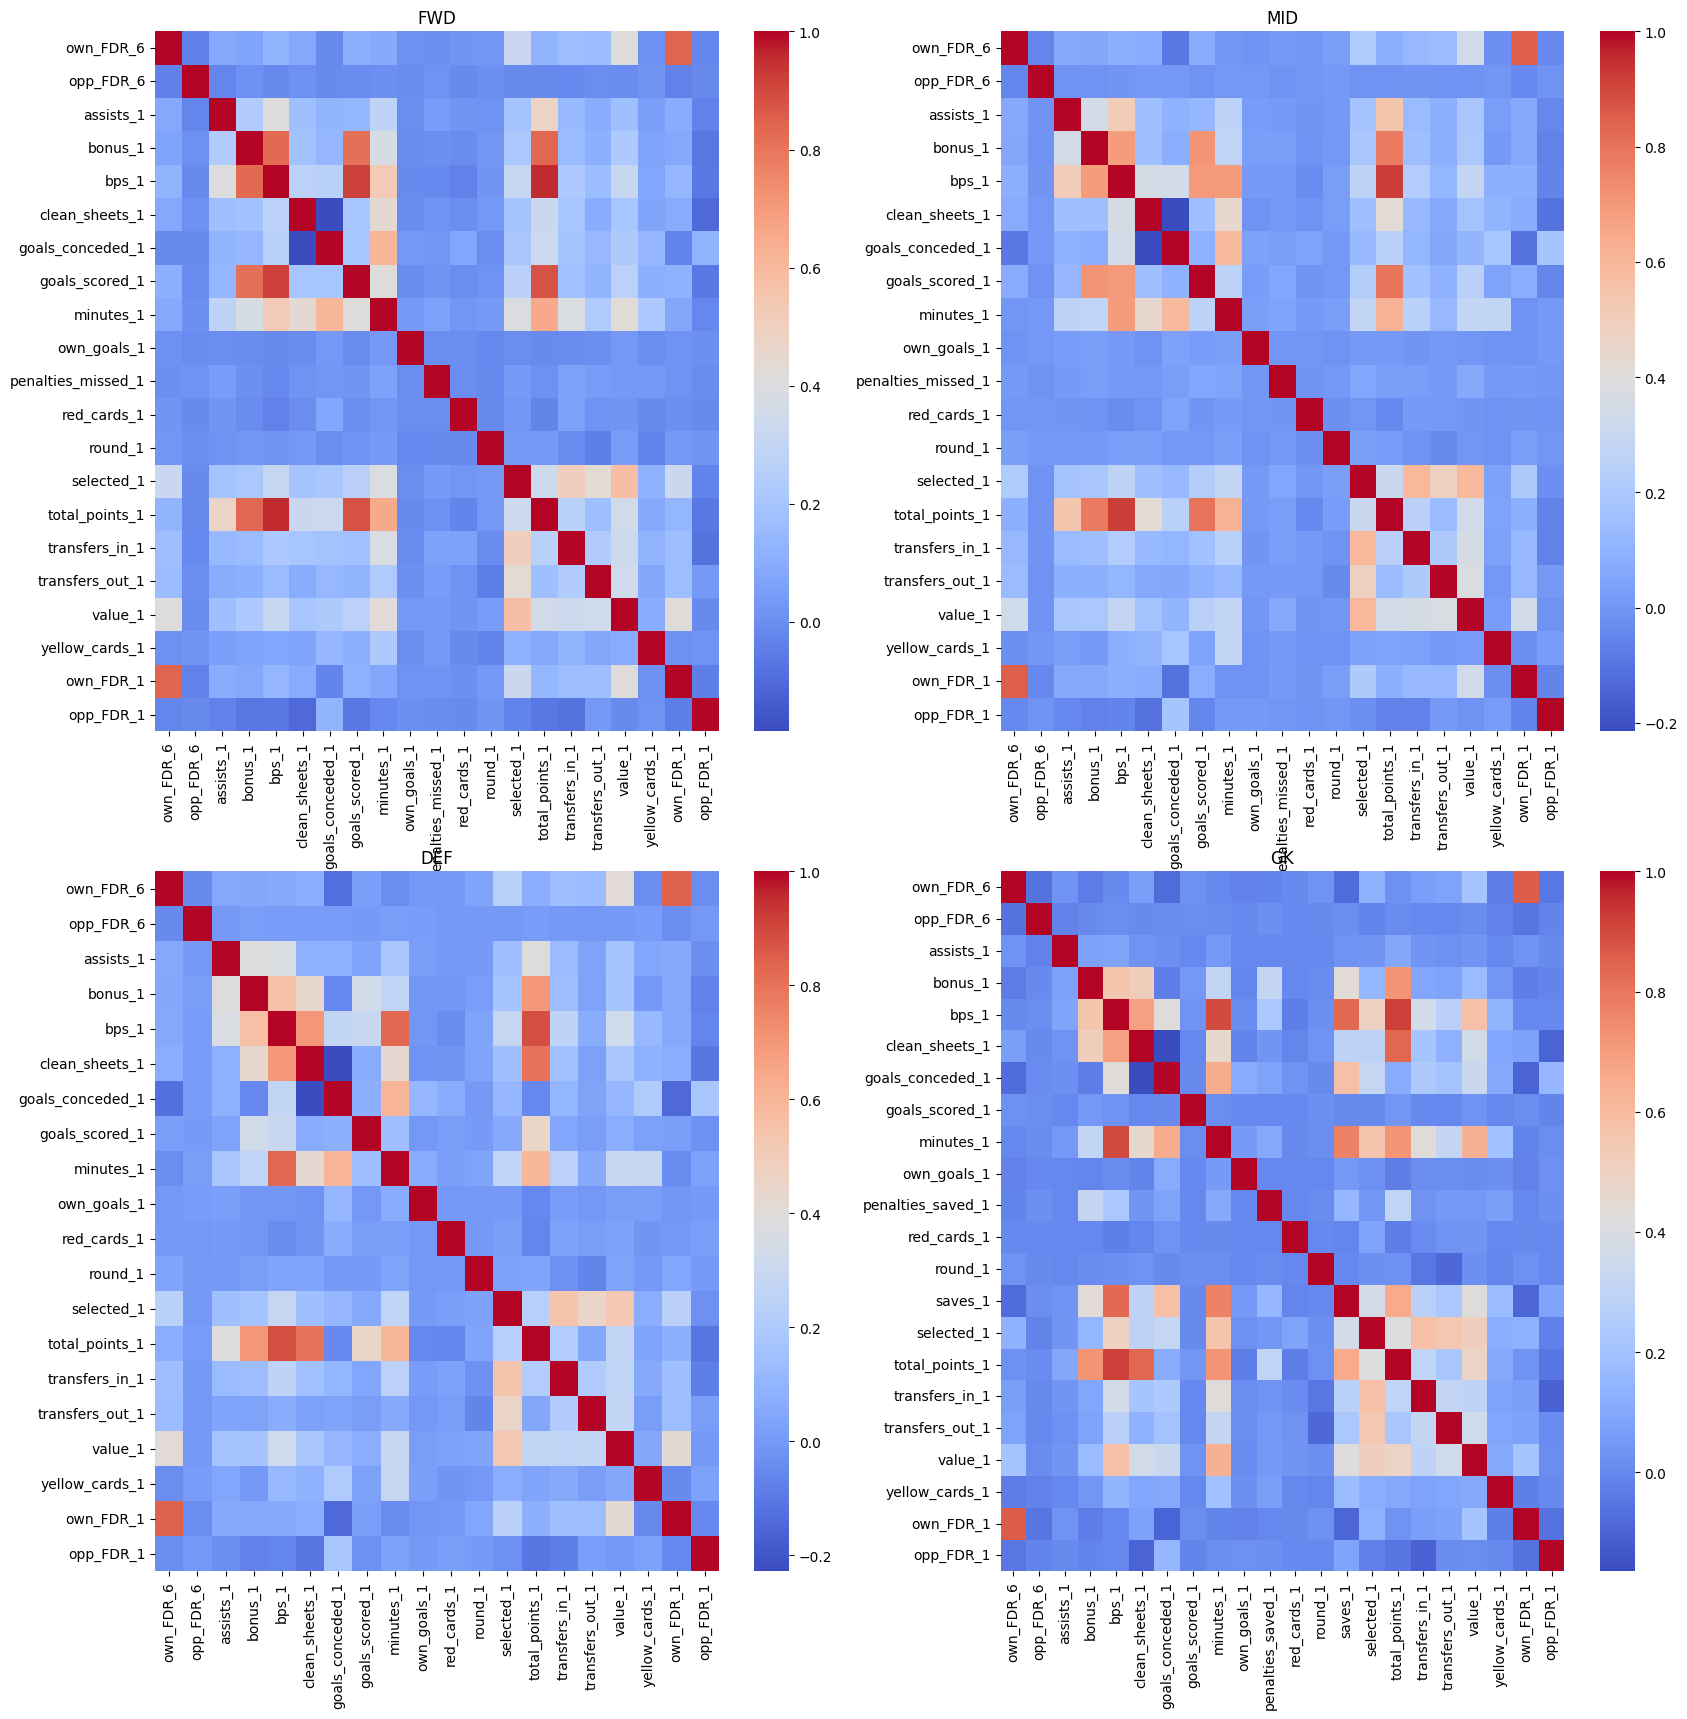

In [6]:
# Get a correlation matrix and view it as a heatmap
def heatmap(data, ax, pos):
    correlation_matrix = data.iloc[:, :int(data.shape[1]//5) + 2].corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', ax = ax)
    ax.set_title(pos)
    return correlation_matrix

fig, axs = plt.subplots(2, 2, figsize = (20, 20))
for i, pos in enumerate(positions):
    correlation_matrix = heatmap(X_train[pos], axs[i//2, i%2], pos)

# **Abstract Model Class and Accuracy Measure**

In [7]:
# General model class which we can use for the model factory
class model:

    # Sets the values of the common variables used for each model
    def base_setter(self, name, preprocess, scoring):
        self.preprocess                 = preprocess
        self.scoring                    = scoring
        self.name                       = name
        self.model                      = None
        self.save_path                  = f"drive/MyDrive/Premier_League_Predictor/saved_models/{name}.pkl"

    # Abstract initializer
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)

    # Training and hyperparameter tuning stays the same across most models
    def train(self, X_train, y_train):
        X_train_pred                    = X_train.copy()
        X_train                         = self.preprocess(X_train)

        # Check if model is already trained
        if os.path.exists(self.save_path):
            self.model                  = joblib.load(self.save_path)

        # Tune hyperparameters
        elif self.scoring:
            grid_search = GridSearchCV(
                             estimator  = self.model,
                             param_grid = self.param_grid,
                             scoring    = self.scoring
                          )
            grid_search.fit(X_train, y_train)
            self.model                  = grid_search.best_estimator_
            joblib.dump(self.model, self.save_path)

        # Fit model
        else:
            self.model.fit(X_train, y_train)
            joblib.dump(self.model, self.save_path)

        return self.predict(X_train_pred)

    # Inference
    def predict(self, X):
        X                               = self.preprocess(X)
        return self.model.predict(X)

    # Naming
    def __repr__(self):
      return self.name

trained_models                          = {i:{} for i in positions}

In [8]:
# Run model inference and return PnL on train set, test set
def test_model(model, pos):
    y_train_pred                        = model.predict(X_train[pos])
    y_test_pred                         = model.predict(X_test[pos])

    train_error                         = mean_squared_error(y_train_pred, y_train[pos])
    test_error                          = mean_squared_error(y_test_pred, y_test[pos])

    return train_error, test_error

train_error                             = {i:{} for i in positions}
test_error                              = {i:{} for i in positions}

# **Model Factory**

In [9]:
# Some linear models for the factory

# Ridge regression
class ridge(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = Ridge()
        self.param_grid                 = [{'alpha': [10**n for n in range(-3, 3)]}]

# Lasso regression
class lasso(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = Lasso()
        self.param_grid                 = [{'alpha': [10**n for n in range(-3, 2)]}]

# Combination of ridge and lasso
class elasticnet(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = ElasticNet()
        self.param_grid                 = [{'alpha':    [10**n for n in range(-3, 3)]},
                                           {'l1_ratio': [10**n for n in range(-3, 1)]}]

In [10]:
# Some tree-based models

# XGboost for Regression on PnL
class xgboost(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error', objective = 'reg:squarederror'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = xgb.XGBRegressor(objective = objective)
        self.param_grid                 = { 'max_depth': [3, 4, 5],
                                            'learning_rate': [1e-1, 1e-2, 1e-3],
                                            'n_estimators': [100, 200, 300] }

# # CatBoost for Classification of profitable trades
# class catboost_classifier(model):
#     def __init__(self, name, preprocess = lambda X : X, scoring = None):
#         self.base_setter(name, preprocess, scoring)
#         self.model                      = CatBoostClassifier(verbose = 0)
#         self.param_grid                 = { 'depth': [4, 6],
#                                             'learning_rate': [0.01, 0.1],
#                                             'l2_leaf_reg': [3], }

In [11]:
# Now a neural network
class Dense_Neural(model):
    def __init__(self, name, preprocess = lambda X : X.values, scoring = None, n = 67, optimizer = 'Adam'):
        self.base_setter(name, preprocess, scoring)
        self.save_path                  = f"drive/MyDrive/Premier_League_Predictor/saved_models/{name}.keras"
        self.model                      = Sequential([
                                              layers.Dense(128, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(64, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(32, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(16, activation='relu'),
                                              layers.Dropout(.2)
                                          ])
        self.param_grid                 = None
        self.model.compile(optimizer    = optimizer,
                           loss         = 'mean_squared_error')
        self.callbacks                  = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                                             patience=2, min_lr=0.0001)]
    def train(self, X_train, y_train):
        X_train_pred                    = X_train.copy()
        X_train                         = self.preprocess(X_train)
        if os.path.exists(self.save_path):
            self.model                  = keras.models.load_model(self.save_path)
        else:
            x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)
            self.model.fit(x_train, y_train,
                           epochs          = 10,
                           validation_data = (x_val, y_val),
                           callbacks       = self.callbacks)
            self.model.save(self.save_path)
    def predict(self, X):
        X                                = self.preprocess(X)
        return self.model.predict(X)

# **Model Losses and Comparison**

In [12]:
models                                        = {i:{} for i in positions}

for pos in positions:
    # What if we did every trade?
    models[pos][f'{pos}_use_means']                  = None
    trained_models[pos][f'{pos}_use_means']          = None
    y_train_pred                                     = pd.concat([X_train[pos][f"total_points_{i}"] for i in range(1, 6)], axis=1).sum(axis=1)/5
    y_test_pred                                      = pd.concat([X_test[pos][f"total_points_{i}"] for i in range(1, 6)], axis=1).sum(axis=1)/5
    train_error[pos][f'{pos}_use_means']             = mean_squared_error(y_train_pred, y_train[pos])
    test_error[pos][f'{pos}_use_means']              = mean_squared_error(y_test_pred, y_test[pos])

    # Linear Models
    models[pos][f'{pos}_elasticnet_no_preprocess']   = elasticnet
    models[pos][f'{pos}_ridge_no_preprocess']        = ridge
    models[pos][f'{pos}_lasso_no_preprocess']        = lasso

    # Tree-based Models
    models[pos][f'{pos}_xgboost_no_tuning']          = xgboost

    # Neural Net
    # models[pos]['Dense_Neural_Adam']               = Dense_Neural
    # models[pos]['Dense_Neural_RMSprop']            = lambda name : Dense_Neural(name, optimizer = 'RMSprop')

    # Train-test loop for model factory
    for i, name in enumerate(models[pos].keys()):
        if not name in trained_models[pos]:
            temp                                     = models[pos][name](name)
            temp.train(X_train[pos], y_train[pos])
            trained_models[pos][name]                = temp
        if not name in train_error[pos]:
            train_error[pos][name], test_error[pos][name] = test_model(trained_models[pos][name], pos)
        print(f'Model: {name}; Train Error: {train_error[pos][name]}; Test Error: {test_error[pos][name]}')

Model: FWD_use_means; Train Error: 8.034412926391381; Test Error: 7.614913793103449
Model: FWD_elasticnet_no_preprocess; Train Error: 6.928287632058456; Test Error: 6.455195288609735
Model: FWD_ridge_no_preprocess; Train Error: 6.751775655402161; Test Error: 6.576556535209023
Model: FWD_lasso_no_preprocess; Train Error: 6.990388024815043; Test Error: 6.436200383840212
Model: FWD_xgboost_no_tuning; Train Error: 5.84324016870757; Test Error: 6.281473295159364
Model: MID_use_means; Train Error: 6.292893870652077; Test Error: 5.802555160142349
Model: MID_elasticnet_no_preprocess; Train Error: 5.333402003694716; Test Error: 4.9051450188823
Model: MID_ridge_no_preprocess; Train Error: 5.318093695799057; Test Error: 4.922028761677527
Model: MID_lasso_no_preprocess; Train Error: 5.350421438469999; Test Error: 4.89510069965518
Model: MID_xgboost_no_tuning; Train Error: 5.193223589836963; Test Error: 4.837356319816912
Model: DEF_use_means; Train Error: 6.629384243076096; Test Error: 7.0679690189

# **Results Visualization**

In [ ]:
train_pnl_arr  = [train_error[pos][i] for i in models.keys()]
plt.figure(figsize = (25,6))
plt.bar(models.keys(), train_pnl_arr)
plt.xlabel('Model')
plt.ylabel('Profit and Loss')
plt.title('Train PnL Comparison')
plt.xticks(rotation=45)
plt.ylim()

In [ ]:
test_pnl_arr   = [test_error[pos][i] for i in models.keys()]
plt.figure(figsize = (25,6))
plt.bar(models.keys(), test_pnl_arr)
plt.xlabel('Model')
plt.ylabel('Profit and Loss')
plt.title('Test PnL Comparison')
plt.xticks(rotation=45)
plt.ylim()

# **Conclusion**
- The dataset is extremely noisy, and most models perform poorly on it.
- I tried the whole pipeline with normalization on the data, and some models had slightly better performance but Catboost was still the best, and Catboost performed better with unnormalized data (both train and test).
- The objective was to "predict" the target variable, but classifiers performed strictly better in most cases.
- Catboost with reduced (63-dimensional) data and hyperparameter tuning performed the best, and made 5.192 units of profit on the test set, where the trivial model (do_every_trade) made -1.301, and the ideal model (crystal_ball_ideal) made 55.962.
- Given more time, I would explore time-series models and also other decision tree based models, like state of the art iterations of random forest ensemble techniques beyong xgboost and catboost.